# Analysis data with all vectorAnalysis data with disk IO

In [1]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

### Utils

In [2]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(df.iloc[:].index,Values[:bound, group],linewidth=3)
        plt.plot(df.iloc[:].index,Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], loc='right')
        plt.grid()
        plt.xticks(rotation=45)
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group,method):
    plt.matshow(df.iloc[:,group].corr(method=method),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('{}_original'.format(method), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [3]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:4]] = scaler.fit_transform(data[list(data.columns)[:4]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,[0,1,2,3]] = scaler.fit_transform(data.iloc[:,[0,1,2,3]])     
    
    
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


In [52]:
all_vector_path = "./Dataset/OPTIdata/6v_1029.csv"
data5v_with_diskio = "./Dataset/OPTIdata/5v_180_1029.csv"
data6v_with_diskio = "./Dataset/OPTIdata/6v_180_1029.csv"

df = read_data(data6v_with_diskio,o_dtname="datetime",c_dtname = 'dt')
df.head()

host     0
name     0
value    0
dtype: int64


,host,name,value
dt,,,
2021-10-29 14:56:49,TWKHH01OPTIPW6V,Disk (0 C:) - Avg. Disk sec/Transfer (Latency),0.0000
2021-10-29 14:56:49,TWKHH01OPTIPW6V,Disk (0 C:) - Average Disk Bytes Read,0.0000
2021-10-29 14:56:49,TWKHH01OPTIPW6V,Disk (0 C:) - Average Disk Bytes Write,0.0000
2021-10-29 14:56:49,TWKHH01OPTIPW6V,Disk (1 D:) - Avg. Disk Queue Length,0.0000
2021-10-29 14:56:49,TWKHH01OPTIPW6V,Disk (1 D:) - % Idle Time,100.0014


In [26]:
for i,name in enumerate(col):
    if "Free disk space" in name:
        print("{}: {}".format(i,name))

21: Free disk space on C: (%)
22: Free disk space on D: (%)


Disk (1 D:) - % Disk saturation
Disk (1 D:) - % Idle Time
Disk (1 D:) - Average Disk Bytes Read
Disk (1 D:) - Average Disk Bytes Total
Disk (1 D:) - Average Disk Bytes Write
Disk (1 D:) - Avg. Disk Queue Length
Disk (1 D:) - Avg. Disk sec/Read (Latency)
Disk (1 D:) - Avg. Disk sec/Transfer (Latency)
Disk (1 D:) - Avg. Disk sec/Write (Latency)
Disk (1 D:) - Current Disk Queue Length
Free disk space on C: (%)
Free disk space on D: (%)
Memory used  (%)
                     Memory used  (%)
dt                                   
2021-10-29 14:56:45           81.6550
2021-10-29 14:53:45           78.7106
2021-10-29 14:50:45           75.6086
2021-10-29 14:47:45           74.6808
2021-10-29 14:44:45           74.1825


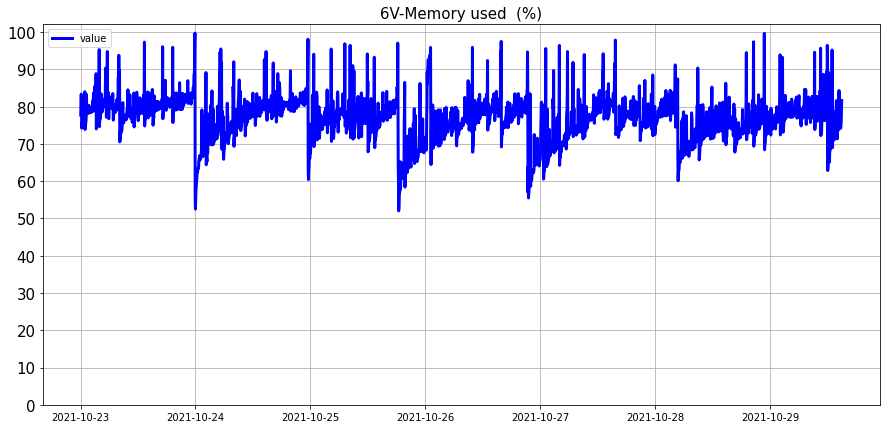

In [74]:
from IPython.display import clear_output

col = np.unique(df.name.values)
i=1
df_list = []
notice = ""
for col_name in col:
    
    filename = col_name.replace("."," ")
    filename = filename.replace("/"," ")
    filename = filename.replace("%","percent ")
    filename = filename.replace(":"," disk")
    print(col_name)
    if "D:" in col_name:
        continue
    if "Free disk space" in col_name:
        continue
    
    tmp_df = df[df["name"]==col_name].drop(["host","name"],axis=1)
    tmp_df = tmp_df.rename(columns={'value':col_name })
    print(tmp_df.head())
    df_list.append(tmp_df)
    plt.plot(tmp_df.loc[:"2021-10-23",col_name],label="value",linewidth=3,color='blue')
    
    
    if "Idle Time" in col_name:
        notice=" - Time  < 20 may be overloaded"
        
    if "Queue Length" in col_name:
        notice=" - length > 2 may be poor performance"
    
    if "Latency" in col_name:
        notice=" - should be below 0.025 ms"
        
    plt.title("6V-{}{}".format(col_name,notice),fontsize=15)
    plt.legend()
    if "%" in col_name:
        plt.yticks(range(0,110,10),fontsize=15)
    elif "Queue" in col_name:
        plt.yticks(range(0,20,2),fontsize=15)
    elif "Latency" in col_name:
        plt.yticks(np.arange(0,3.25,0.25),fontsize=15)
    else:   
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    
    #Server_mantain/Zabbix_Online_detection/Dataset/OPTIdata/all_vector_analysis
    plt.grid()
    plt.savefig("./Dataset/OPTIdata/diskio_vector_analysis/{}-6V-diskio_vector.jpg".format(filename))
    notice=""
    
    plt.show()
    clear_output(wait=True)
    
concat_df = pd.concat(df_list,axis=1)
concat_df.fillna(method='ffill', inplace=True)
concat_df.fillna(method='bfill', inplace=True)



In [8]:
for name in concat_df.columns[0]:
    
    filename = name.replace("."," ")
    filename = filename.replace("/"," ")
    filename = filename.replace("%","percent ")
    filename = filename.replace(":"," disk")
    plt.plot(concat_df[name].loc["2021-10-23":].resample("h").mean(),label=name,linewidth=3)
    plt.title("6V-{}".format(name),fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    #Server_mantain/Zabbix_Online_detection/Dataset/OPTIdata/all_vector_analysis
    plt.savefig("./Dataset/OPTIdata/diskio_vector_analysis/{}-6V-diskio.jpg".format(filename))
    clear_output(wait=True)
    plt.show()

KeyError: 'C'

In [31]:
concat_df.loc[:,concat_df.columns[1]].values.shape

(190466,)

In [30]:
from pyts.bag_of_words import BagOfWords
from pyts.datasets import load_gunpoint



window_size, word_size = 30, 1
bow = BagOfWords(window_size=window_size, word_size=word_size,
                 window_step=window_size, numerosity_reduction=False)
X_bow = bow.transform(concat_df.loc[:,concat_df.columns[1]].values.reshape(-1,1))

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\pyts\bag_of_words\bow.py:243: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  warnings.warn("BagOfWords has been reworked in 0.11 in order to match "


ValueError: If 'window_size' is an integer, it must be greater than or equal to 1 and lower than or equal to n_timestamps (got 30).

(50, 150)

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         28.566922            39.851956   
2021-06-20 10:00:00         28.828743            37.081960   
2021-06-20 11:00:00         27.201200            37.182560   
2021-06-20 12:00:00         28.462700            31.697695   
2021-06-20 13:00:00         27.996105            43.175465   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

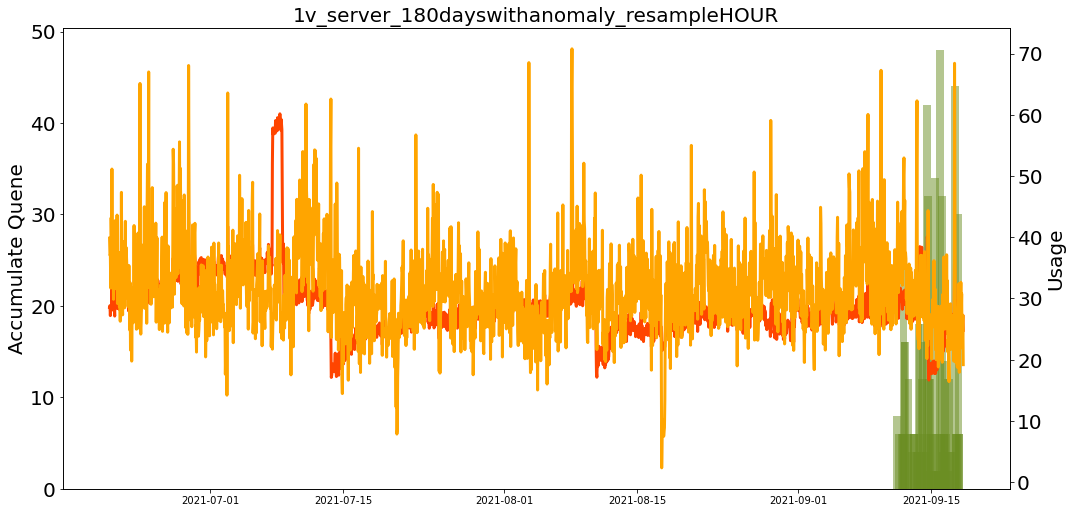

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         14.113606             1.207067   
2021-06-20 10:00:00         14.095523             1.461820   
2021-06-20 11:00:00         14.128880             1.280370   
2021-06-20 12:00:00         14.089222             1.241520   
2021-06-20 13:00:00         14.128913             1.258165   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

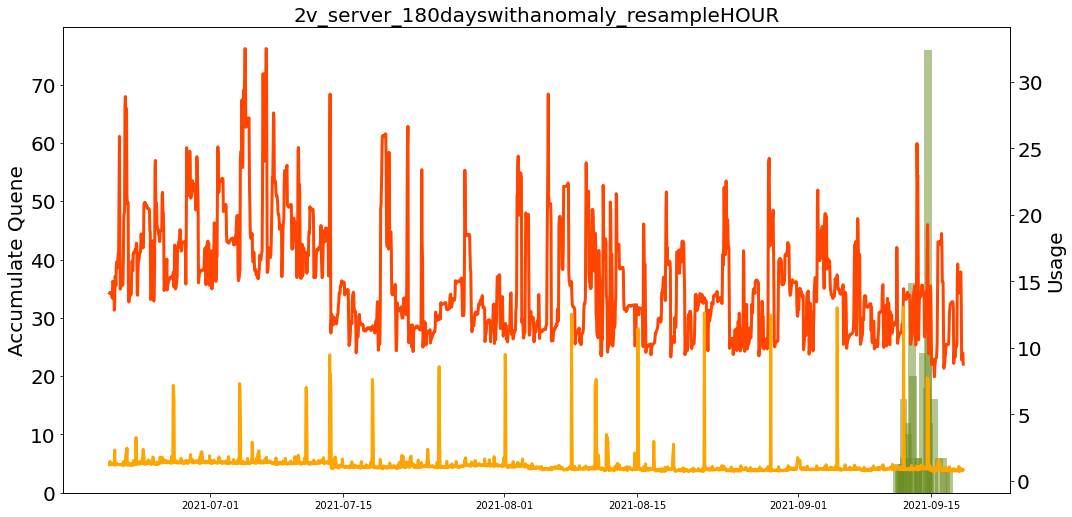

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         19.636733             8.287033   
2021-06-20 10:00:00         20.635300            10.620855   
2021-06-20 11:00:00         19.013268             8.150290   
2021-06-20 12:00:00         20.051527             6.334245   
2021-06-20 13:00:00         19.982570             8.900310   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

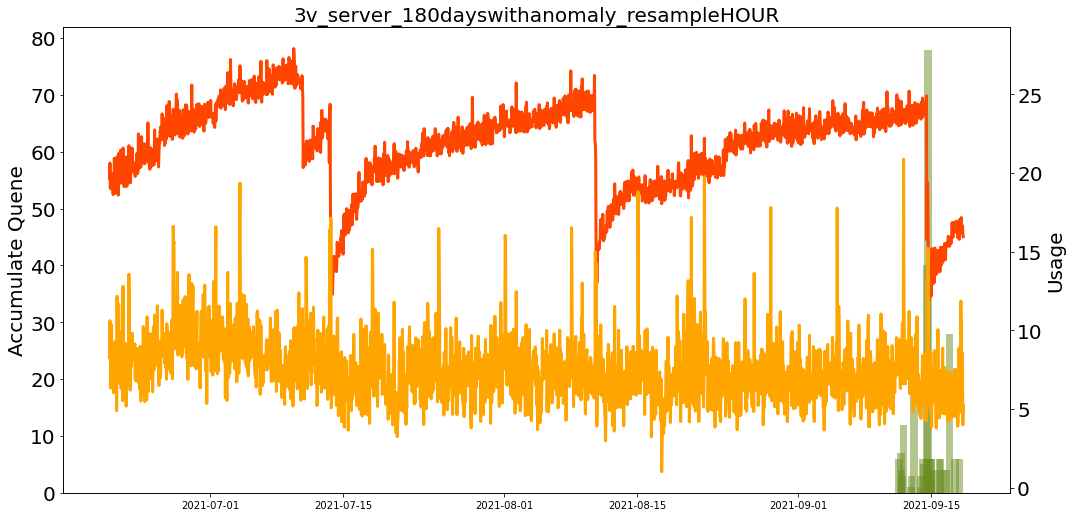

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         12.935383             1.118944   
2021-06-20 10:00:00         12.926137             1.078355   
2021-06-20 11:00:00         12.936700             1.078200   
2021-06-20 12:00:00         12.991245             1.120410   
2021-06-20 13:00:00         13.001953             1.094930   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

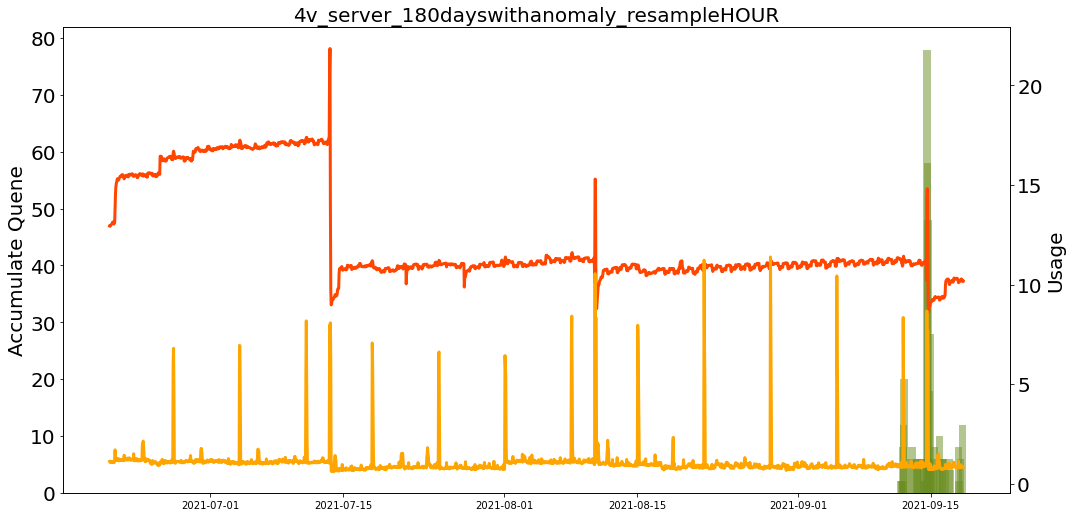

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         15.324467             4.633911   
2021-06-20 10:00:00         14.341952             8.398715   
2021-06-20 11:00:00         14.190687             6.687040   
2021-06-20 12:00:00         15.669625             9.170250   
2021-06-20 13:00:00         14.167898             6.942100   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

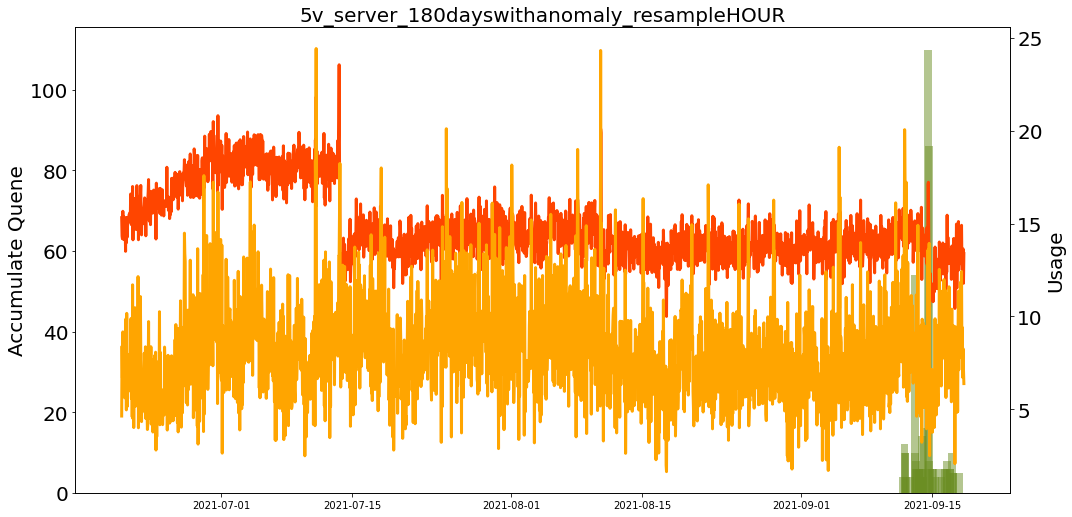

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 10:00:00         68.997344            80.346878   
2021-06-20 11:00:00         69.694937            77.582825   
2021-06-20 12:00:00         62.959915            77.360200   
2021-06-20 13:00:00         64.110505            78.613925   
2021-06-20 14:00:00         63.443767            76.853580   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06-20 12:00:00                                      0.0   
2021-06

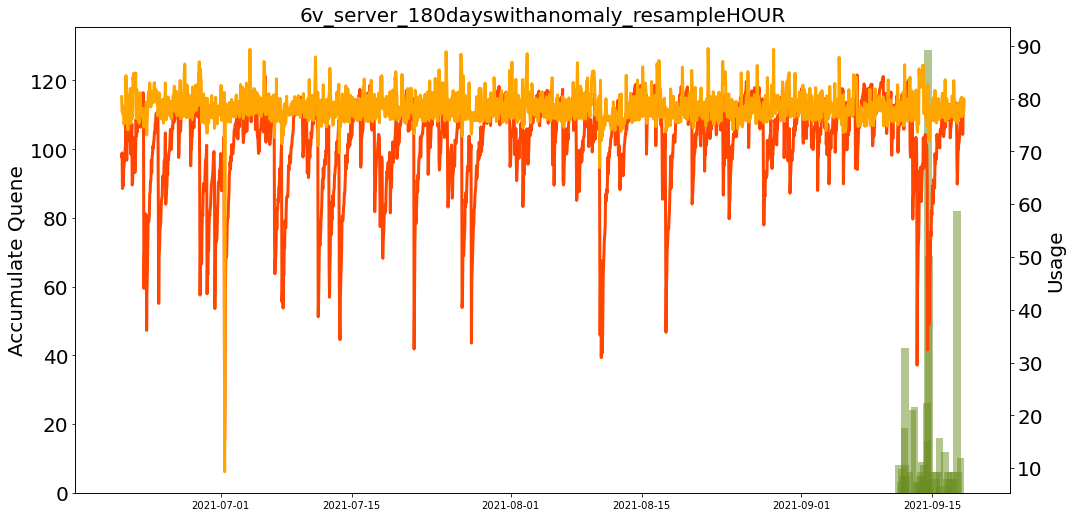

In [86]:
#Usage vs. Quene mean

for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):
    figsize(15,7)
    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    df = df.loc[:,:]
    server_name = path.split("\\")[-1].split("_")[0]
    print(df.head())
    fig, ax1 = plt.subplots()
    
    
    
    ax2 = ax1.twinx()
    
    
    
    ax1.set_ylabel("Accumulate Quene",fontsize=20)
    ax1.bar(df["Disk (0 C:) - Current Disk Queue Length"].index.values,
            df["Disk (0 C:) - Current Disk Queue Length"].values,
            label="Number of Accumulate Quene",
            zorder=1,
            alpha = 0.5,
            color='olivedrab'
           )
    ax1.tick_params(axis='y',labelsize=20)
    
    ax2.set_ylabel("Usage",fontsize=20)
    ax2.plot(df["Memory used  (%)"].index.values,
             df["Memory used  (%)"].values,
             label="Memory used  (%)",
             zorder=10,
            linewidth=3,
            color='orangered')
    ax2.plot(df["CPU utilization (%)"].index.values,
             df["CPU utilization (%)"].values,
             label="CPU utilization (%)",
             zorder=10,
            linewidth=3,
            color='orange')
    #ax1.legend(fontsize='xx-large')
    
    ax2.tick_params(axis='y',labelsize=20)
    ax2.tick_params(axis='x',labelsize=20)
    
    fig.tight_layout()
    plt.title("{}_server_180dayswithanomaly_resampleHOUR".format(server_name),fontsize=20)
    #plt.xtick(fontsize=20)
    plt.xlabel("Datetime",fontsize=10)
    
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR_line_and_bar.jpg".format(server_name)),bbox_inches="tight")
    plt.show()
    

In [33]:
concat_df.loc[:,concat_df.columns[1]].values.shape

(190466,)

In [ ]:
concat_df.loc[:,concat_df.columns[1]].values

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


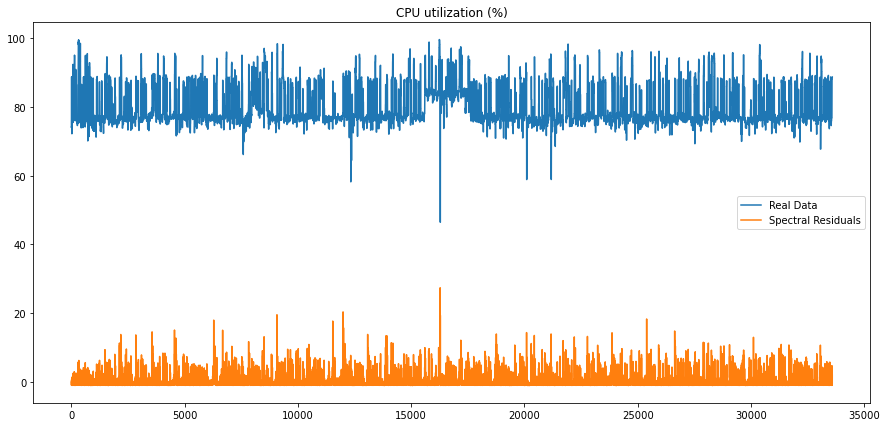

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


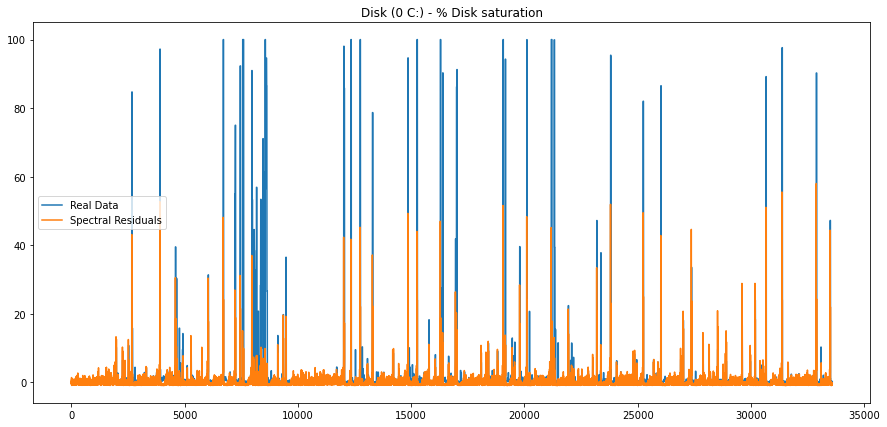

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


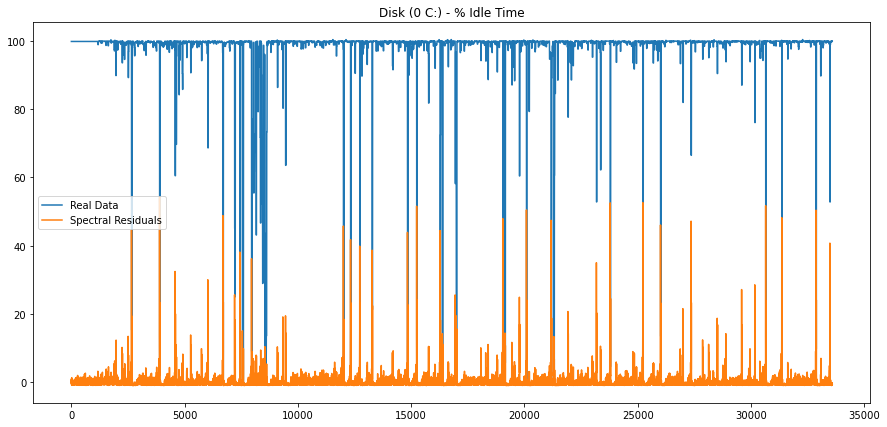

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


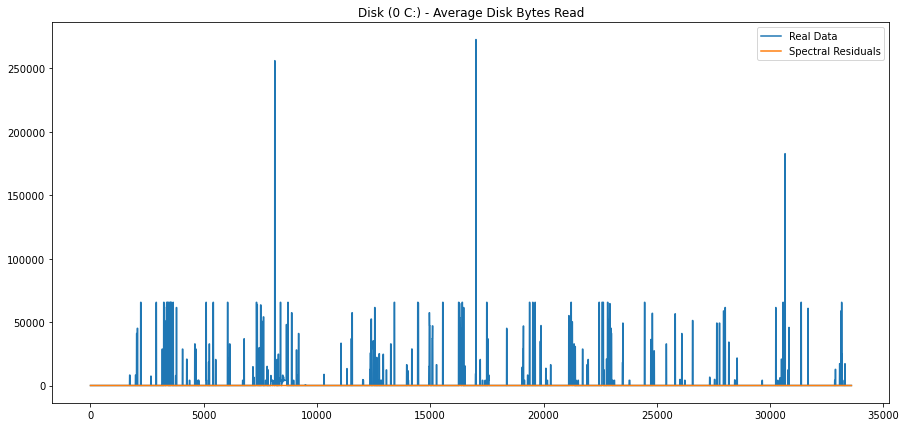

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


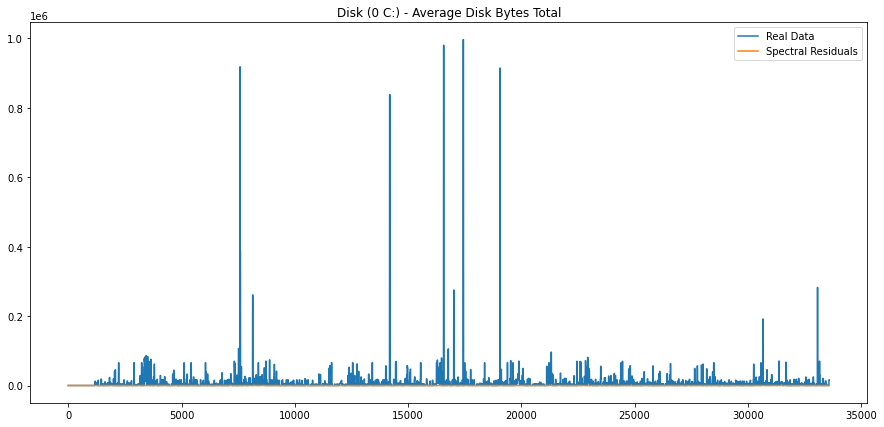

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


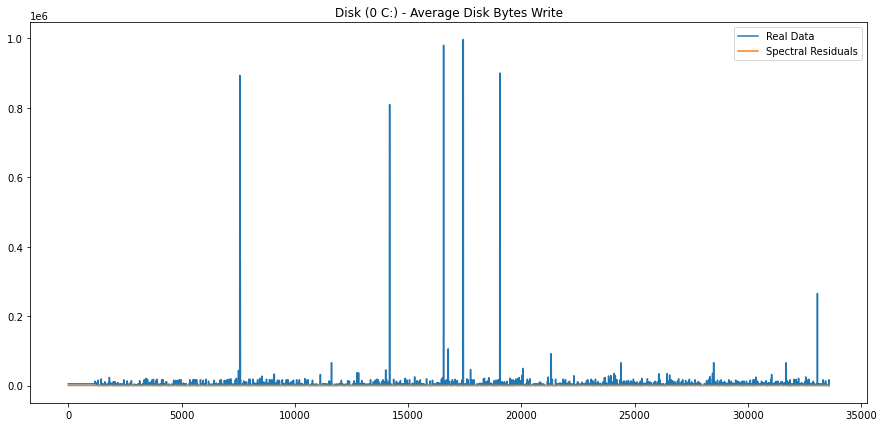

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


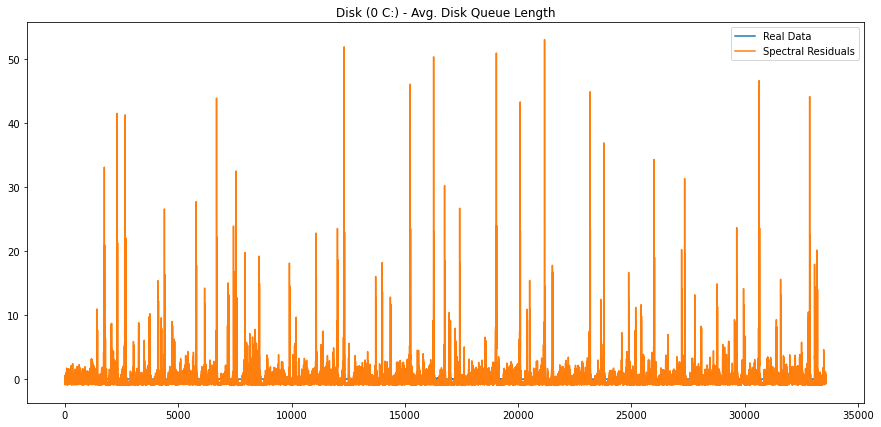

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


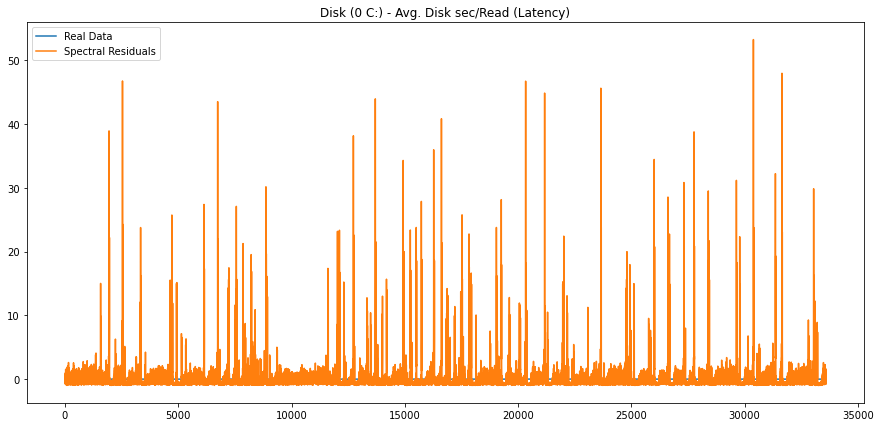

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


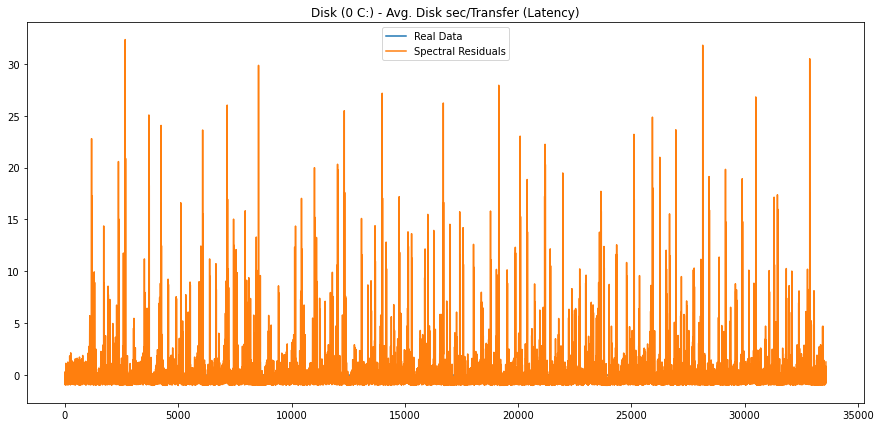

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


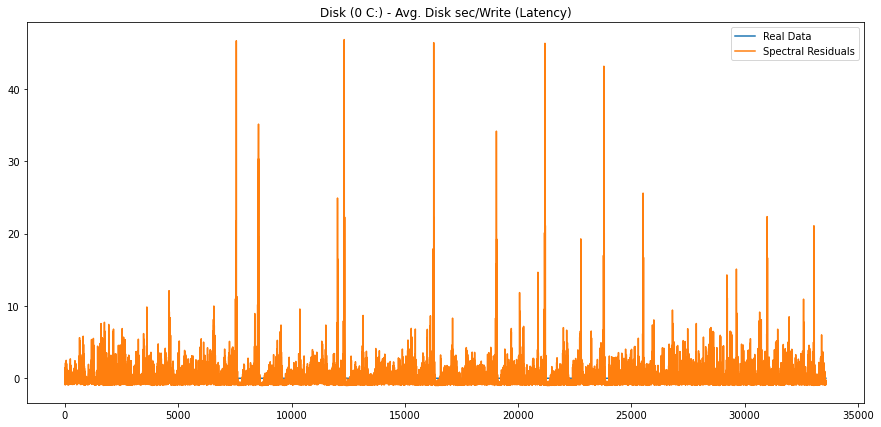

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


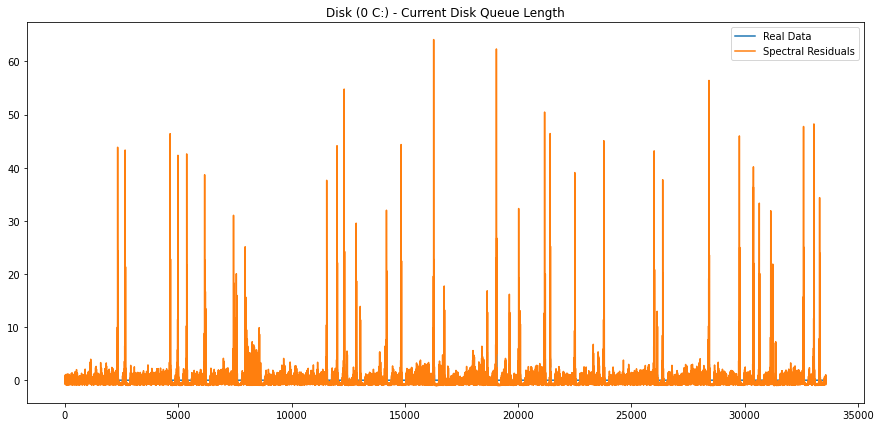

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


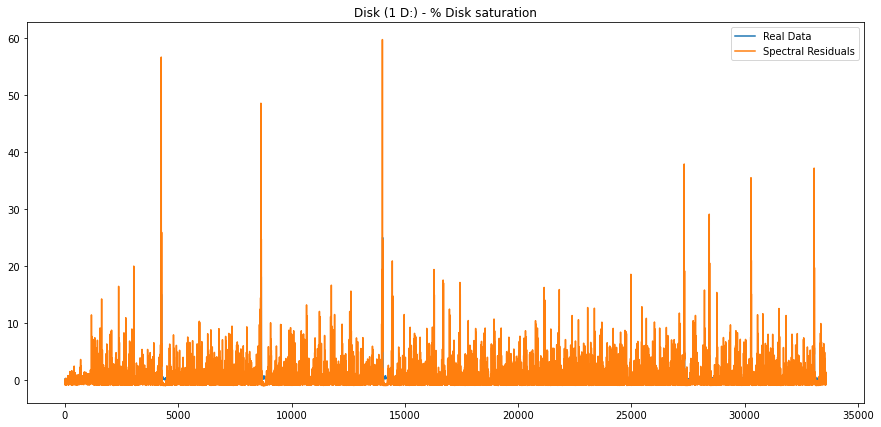

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


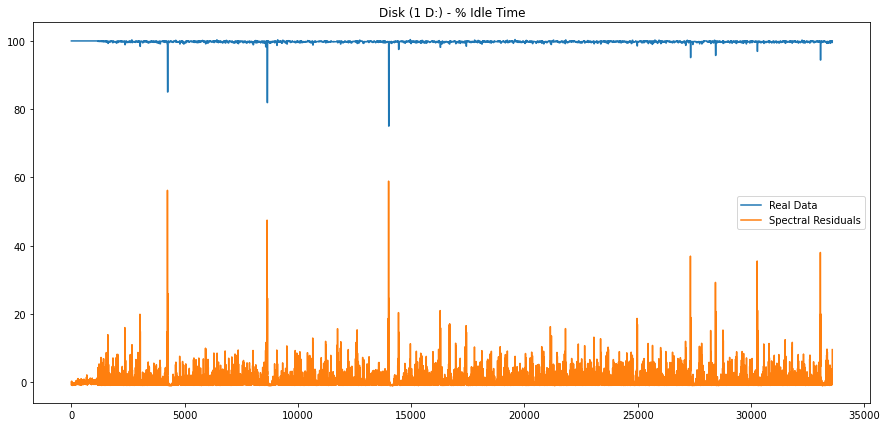

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


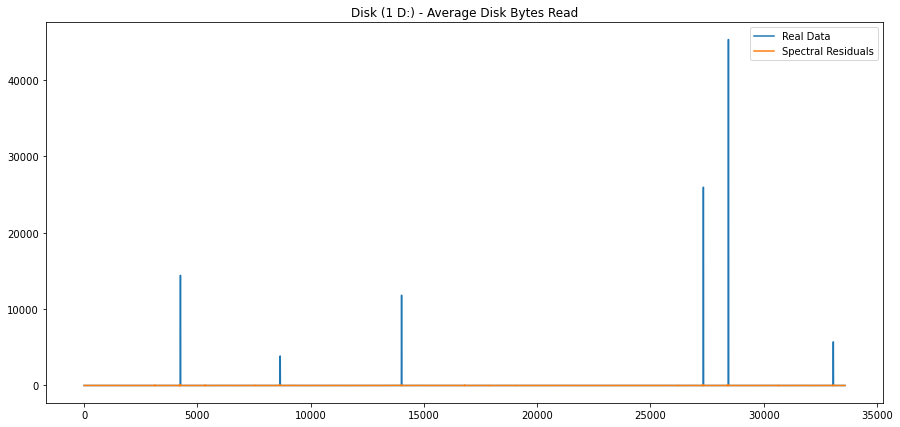

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


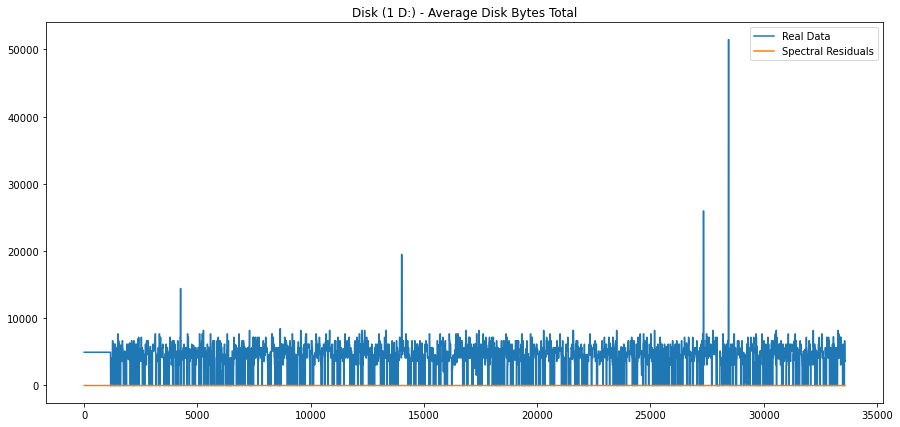

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


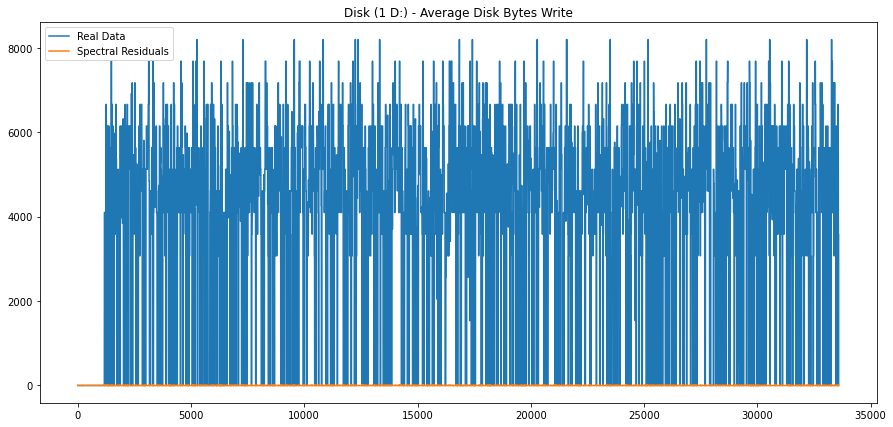

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


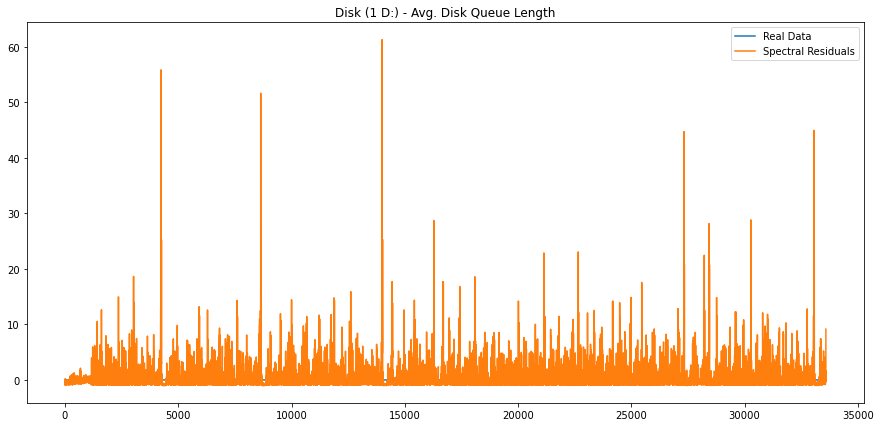

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


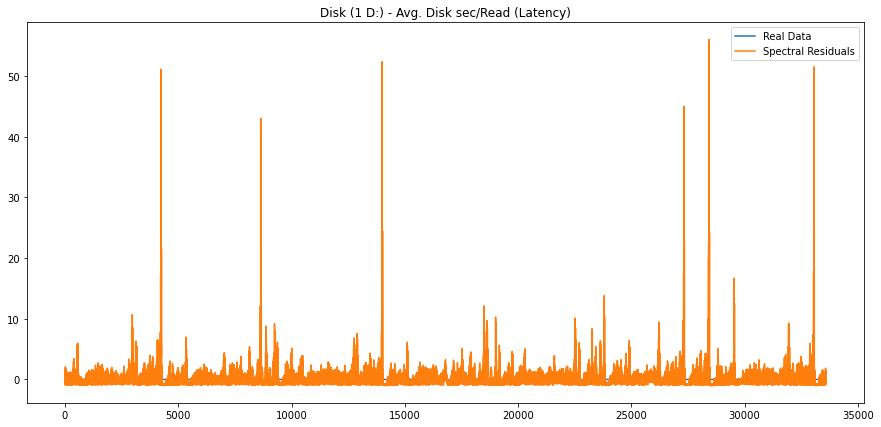

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


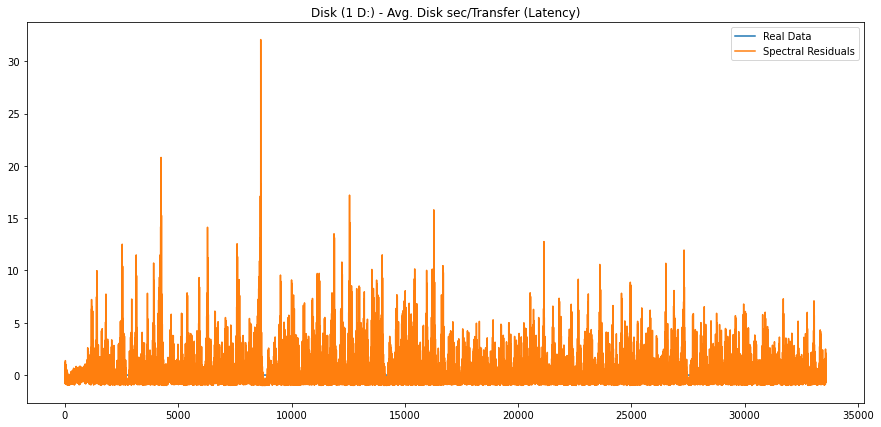

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


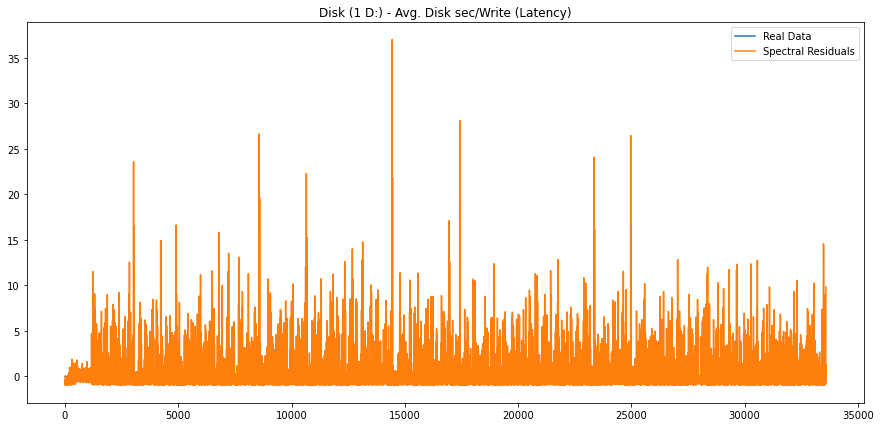

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


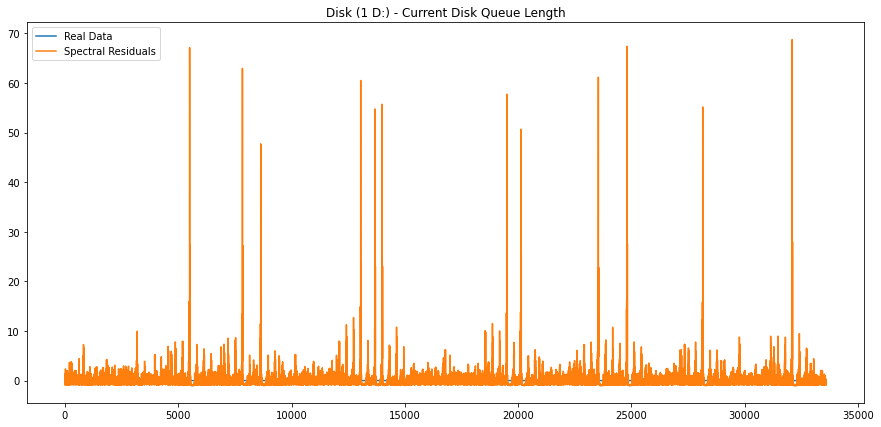

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


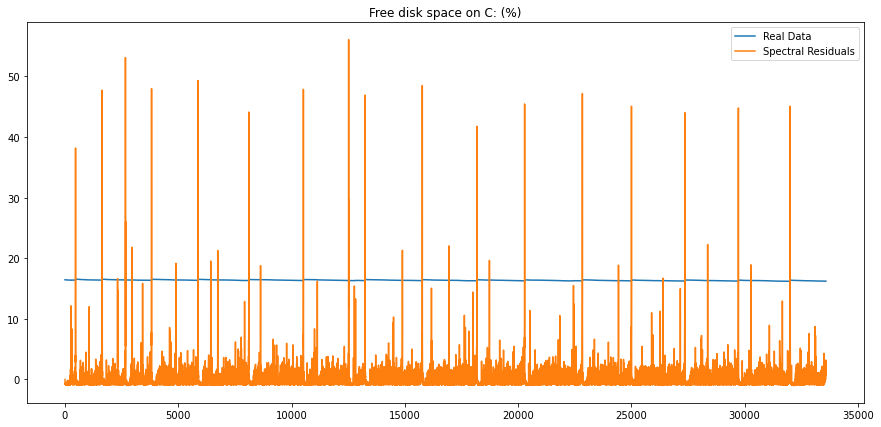

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


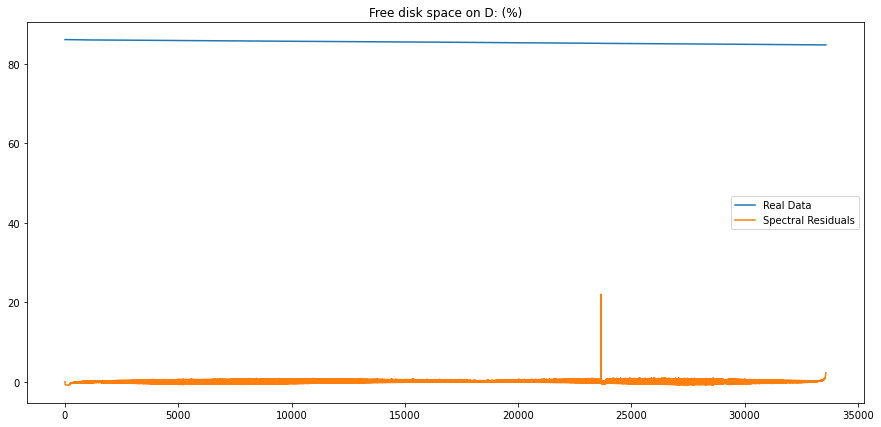

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\sranodec\util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


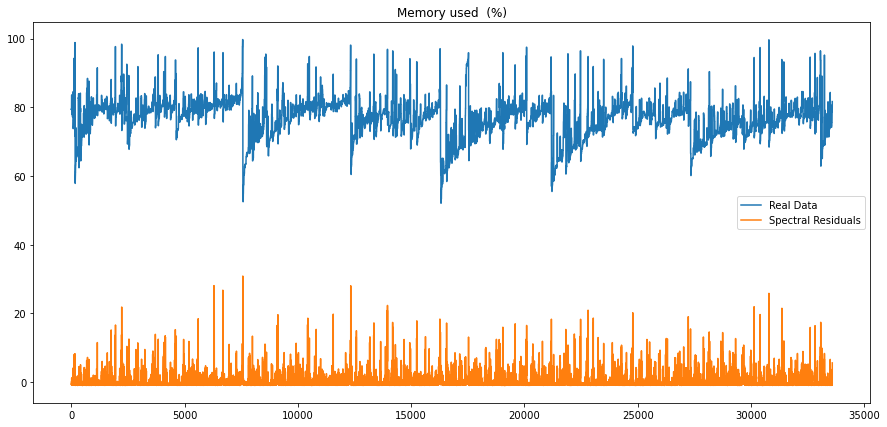

In [41]:
import sranodec as anom
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=200


for i in concat_df.columns:
    test_signal = concat_df.loc["2021-10-22":,i].values
    spec = anom.Silency(amp_window_size, series_window_size, score_window_size)
    plt.plot(test_signal,label="Real Data")

    score = spec.generate_anomaly_score(test_signal)
    plt.plot(score,label="Spectral Residuals")
    plt.legend()
    plt.title(i)
    plt.show()